In [1]:
pip install textstat

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import seaborn as sns

## Loading the data

In [72]:
df = pd.read_parquet("badwords.gzip")

In [73]:
df.head()

,class,tweet
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."


In [82]:
df['Class']=1

In [85]:
# df.loc[df['class']==2,'Class']=0

In [87]:
df=df.drop(['class'],axis=1)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23353 entries, 1 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   23353 non-null  object
 1   Class   23353 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


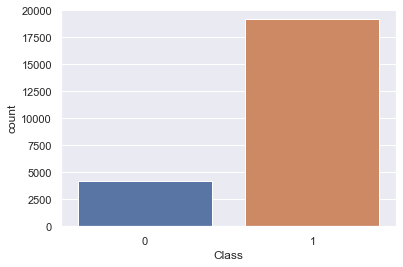

In [89]:
sns.set()
sns.countplot(x = df["Class"])
plt.show()

In [91]:
train_=df.copy()

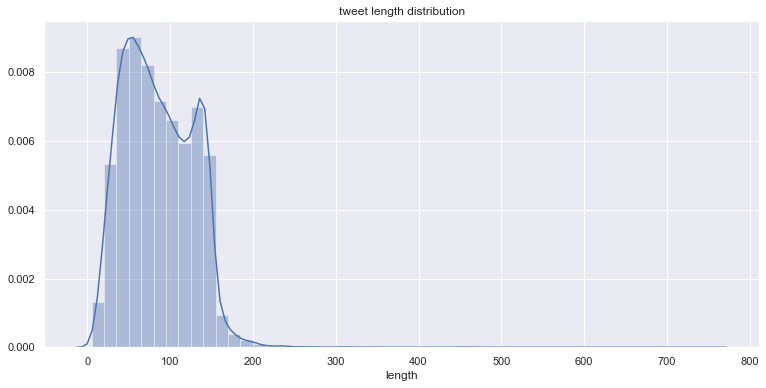

In [92]:
train_['length'] = df["tweet"].str.len()

plt.figure(figsize=(12.8,6))
sns.distplot(train_['length']).set_title('tweet length distribution');

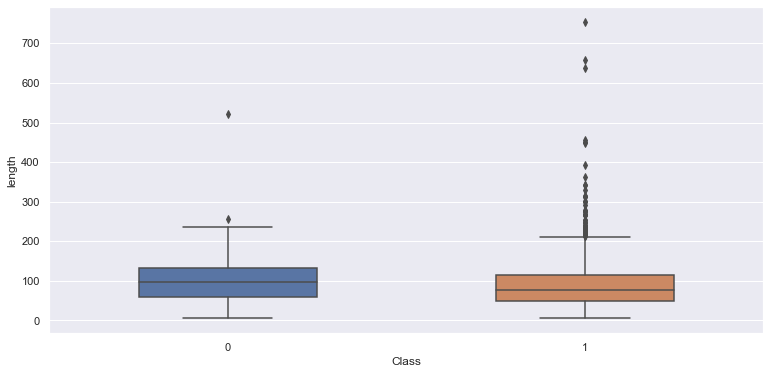

In [94]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=train_, x='Class', y='length', width=.5);

In [95]:
df.describe()

,Class
count,23353.000000
mean,0.821736
std,0.382743
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [96]:
df.columns

Index(['tweet', 'Class'], dtype='object')

### Columns key:

non_offensive = number of CF users who used normal commebnts.


offensive_language = number of CF users who judged the tweet to be offensive.


class = class label for majority of CF users.

    0 - non off
    1 - offensive  language

tweet = raw tweet text


In [97]:
df.head()

,tweet,Class
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1
5,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",1


In [98]:
tweets=df.tweet

## Feature generation

In [14]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text



def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [15]:
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='replace',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.75,
                max_features=10000, min_df=5, ngram_range=(1, 3), norm=None,
                preprocessor=<function preprocess at 0x000001694CE6BF78>,
                smooth_idf=False,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenize at 0x000001694CF8E048>,
             

In [16]:
import warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

In [53]:
len(tfidf[0])

3387

In [19]:
#Get POS tags for tweets and save as a string
import nltk
nltk.download('averaged_perceptron_tagger')

tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [20]:
tweet_tags

['. . . . . NN NN NN NN NN VBZ DT JJ NN NN NN NN NN . . . JJ NN VBD DT NN NN NN VBD DT NN NN NN NN NN JJ JJ NN NN VBP VBZ DT NN NN IN NN NN VBP NN NN NN NN NN NN VBZ DT JJ NN . .',
 '. . . . . . . NN NN VBZ DT JJ NN . . . . NN NN NN NN JJ NN NN NN NN NN JJ NN VBD DT NN NN VBP NN NN DT JJ NN NN NN NN NN VBD DT NN NN NN NN NN NN NN . UH NN JJ NN NN NN NN JJ NN JJ NN NN VBZ DT JJ NN NN NN VBP',
 '. . . . . . . . . NN NN NN NN NN NN NN NN NN NN NN VBP VBZ DT NN NN DT JJ NN NN',
 '. . . . . . . . . . . . . NN NN NN NN NN NN NN JJ VBP JJ NN JJ NN VBZ DT NN DT NN NN JJ NN NN IN NN NN VBP NN NN NN NN NN NN JJ NN IN NN NN VBP NN NN VBP NN NN NN NN VBZ DT NN NN NN NN VBD DT JJ NN NN NN NN NN VBP NN NN NN NN JJ NN NN NN NN NN VBP NN NN VBZ DT',
 '. . . . . . . . . . . . . . . . . . NN NN NN NN NN JJ VBP NN JJ NN NN NN NN NN NN NN NN NN . . JJ IN DT JJ NN NN NN JJ NN NN VBD DT JJ NN NN JJ JJ NN DT JJ NN NN NN NN JJ NN NN NN NN IN NN NN NN NN NN NN NN JJ NN NN NN NN VBP NN NN JJ NN NN JJ VBP JJ NN 

In [21]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [22]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [25]:
pos_vocab

{'CC': 0,
 'CC DT': 1,
 'CC DT JJ': 2,
 'CC DT NN': 3,
 'CC FW': 4,
 'CC IN': 5,
 'CC JJ': 6,
 'CC JJ IN': 7,
 'CC JJ JJ': 8,
 'CC JJ NN': 9,
 'CC NN': 10,
 'CC NN IN': 11,
 'CC NN NN': 12,
 'CC NN VBP': 13,
 'CC VBP': 14,
 'CC VBZ': 15,
 'CC VBZ DT': 16,
 'CD': 17,
 'CD NN': 18,
 'DT CC': 19,
 'DT CC JJ': 20,
 'DT DT': 21,
 'DT DT DT': 22,
 'DT DT JJ': 23,
 'DT DT NN': 24,
 'DT FW': 25,
 'DT FW DT': 26,
 'DT JJ': 27,
 'DT JJ IN': 28,
 'DT JJ JJ': 29,
 'DT JJ NN': 30,
 'DT JJ NNP': 31,
 'DT JJ VBP': 32,
 'DT NN CC': 33,
 'DT NN DT': 34,
 'DT NN FW': 35,
 'DT NN IN': 36,
 'DT NN JJ': 37,
 'DT NN MD': 38,
 'DT NN NNP': 39,
 'DT NN UH': 40,
 'DT NN VB': 41,
 'DT NN VBD': 42,
 'DT NN VBP': 43,
 'DT NN VBZ': 44,
 'DT NN WP': 45,
 'DT NN WRB': 46,
 'DT VB': 47,
 'DT VB DT': 48,
 'DT VBZ': 49,
 'DT VBZ DT': 50,
 'EX': 51,
 'EX VB': 52,
 'EX VB DT': 53,
 'FW': 54,
 'FW CC': 55,
 'FW CC FW': 56,
 'FW CC JJ': 57,
 'FW DT': 58,
 'FW DT DT': 59,
 'FW DT JJ': 60,
 'FW DT NN': 61,
 'FW FW': 62,
 'FW

In [27]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [28]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [29]:
feats = get_feature_array(tweets)

In [30]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [31]:
M.shape

(23353, 3983)

In [37]:
M[0]

array([0., 0., 0., ..., 1., 0., 0.])

In [39]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [42]:
pos_variables[:5]

['CC', 'CC DT', 'CC DT JJ', 'CC DT NN', 'CC FW']

# Running the model

The best model was selected using a GridSearch with 5-fold CV.

In [116]:
X = pd.DataFrame(M)
y = df['Class'].astype(int)

In [117]:
y[:5]

1    1
2    1
3    1
4    1
5    1
Name: Class, dtype: int32

In [103]:
from sklearn.model_selection import train_test_split

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [134]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [135]:
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty='l2', C=0.01))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])

In [136]:
param_grid = [{}] # Optionally add parameters here

In [137]:
grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train, y_train), 
                           verbose=2)

In [138]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=  20.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.3s remaining:    0.0s


[CV] ................................................. , total=  20.8s
[CV]  ................................................................
[CV] ................................................. , total=  19.4s
[CV]  ................................................................
[CV] ................................................. , total=  19.3s
[CV]  ................................................................
[CV] ................................................. , total=  19.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished


In [139]:
y_pred_logreg = model.predict(X_test)

In [61]:
from joblib import dump, load

In [ ]:
dump(model, "logregFT.ml")

## Evaluating the results

In [121]:
report = classification_report( y_test, y_pred_logreg )

In [122]:
print(report)

              precision    recall  f1-score   support

           1       0.96      0.90      0.93      1922
           2       0.64      0.85      0.73       414

    accuracy                           0.89      2336
   macro avg       0.80      0.87      0.83      2336
weighted avg       0.91      0.89      0.90      2336



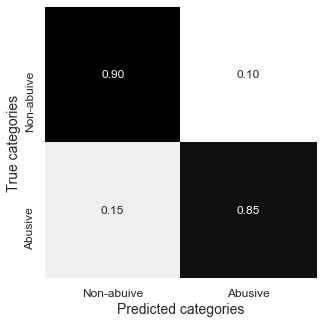

In [123]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_pred_logreg)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Non-abuive','Abusive']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

In [62]:
from sklearn.metrics import *

In [107]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [140]:

l=['Logistic Regression','KNeighborsClassifier','Decision Tree Classifier']
# prepare models
models1 = []
models1.append(('KNN', KNeighborsClassifier()))
models1.append(('Decision Tree', DecisionTreeClassifier()))
models1.append(('RandomForestClassifier',RandomForestClassifier(n_estimators = 100)))
# evaluate each model in turn
results = []
names = []
print('-------------ACCURACY SCORE-----------------')
for name, model in models1:
    model.fit(X_train,y_train)
    y_pred_class = model.predict(X_test)
    acc=metrics.accuracy_score(y_test, y_pred_class)
    results.append(acc)
    names.append(name)
    
    print('='*40)
    print("%s: %f" %(name, acc))
    
acc=metrics.accuracy_score(y_test, y_pred_logreg)
results.append(acc)
print('='*40)
name='LR Fine tuned'
print("%s: %f" %(name, acc))
print('='*40)


-------------ACCURACY SCORE-----------------
KNN: 0.827911
Decision Tree: 0.868151
RandomForestClassifier: 0.880993
LR Fine tuned: 0.885702


In [56]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [65]:
from tensorflow import *
from keras import *

Using TensorFlow backend.


In [226]:
# Text Classification with Simple Neural Network
# The first deep learning model that we are going to develop is a simple deep neural network. Look at the following script:
x=X.values
xtr= x.reshape(-1,x.shape[1],1)
x_train,x_test,y_train,y_test=train_test_split(xtr,y,test_size=0.2)
shapes = x_train.shape
shapes

(18682, 3983, 1)

In [227]:
shapes[1:]

(3983, 1)

In [228]:
import tensorflow as tf
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(shapes[1:])),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 3983)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               509952    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 258       
Total params: 510,210
Trainable params: 510,210
Non-trainable params: 0
_________________________________________________________________


In [229]:
history=model.fit(x_train,y_train, epochs = 20)

Train on 18682 samples
Epoch 1/20
18682/18682 [==============================] - 4s 238us/sample - loss: 0.3392 - accuracy: 0.8674
Epoch 2/20
18682/18682 [==============================] - 4s 220us/sample - loss: 0.1798 - accuracy: 0.9232
Epoch 3/20
18682/18682 [==============================] - 4s 217us/sample - loss: 0.1347 - accuracy: 0.9467
Epoch 4/20
18682/18682 [==============================] - 4s 216us/sample - loss: 0.0972 - accuracy: 0.9638
Epoch 5/20
18682/18682 [==============================] - 4s 218us/sample - loss: 0.0690 - accuracy: 0.9750
Epoch 6/20
18682/18682 [==============================] - 4s 216us/sample - loss: 0.0554 - accuracy: 0.9813
Epoch 7/20
18682/18682 [==============================] - 4s 214us/sample - loss: 0.0413 - accuracy: 0.9858
Epoch 8/20
18682/18682 [==============================] - 4s 212us/sample - loss: 0.0371 - accuracy: 0.9874
Epoch 9/20
18682/18682 [==============================] - 4s 212us/sample - loss: 0.0289 - accuracy: 0.9902
Epoch

In [181]:
y_predict_nn = []
for i in model.predict(x_test):
    y_predict_nn.append(np.argmax(i))

In [182]:
y_predict_nn[:5]

[1, 1, 1, 0, 0]

In [183]:
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
print('accuracy',round(accuracy_score(y_test,y_predict_nn)*100,4),'%')
print('----------------------------------------')
print('confusion matrix\n',confusion_matrix(y_test,y_predict_nn))
print('----------------------------------------')

print("classification report\n", classification_report(y_test, y_predict_nn))

accuracy 89 %
----------------------------------------
confusion matrix
 array([[ 560,  288],
       [ 246, 3577]], dtype=int64)
----------------------------------------
classification report
               precision    recall  f1-score   support

           0       0.69      0.66      0.68       848
           1       0.93      0.94      0.93      3823

    accuracy                           0.89      4671
   macro avg       0.81      0.80      0.80      4671
weighted avg       0.88      0.89      0.88      4671



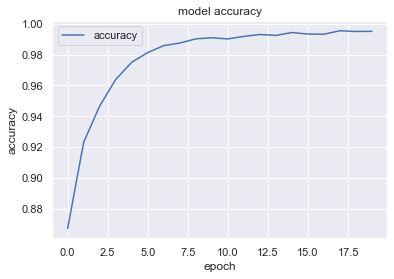

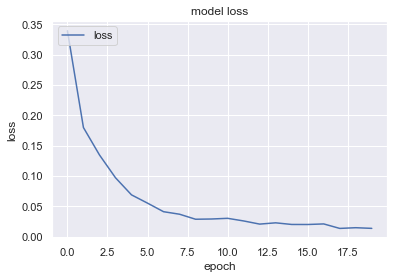

In [232]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy'], loc='upper left')

plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

In [ ]:
# dump(model, "Neuralnetw.ml")

In [184]:
nn_res=accuracy_score(y_test,y_predict_nn)

In [187]:
nn_res

0.8856775850995504

In [147]:
logreg_res = accuracy_score(y_test,y_pred_logreg)

In [189]:
results.append(nn_res)

In [190]:
names , results

(['KNN', 'DecT', 'RF', 'LR-FT', 'NN'],
 [0.8279109589041096,
  0.8681506849315068,
  0.8809931506849316,
  0.8857020547945206,
  0.8856775850995504])

In [179]:
names=['KNN','DecT','RF','LR-FT','NN']

LR-FT has highest accuracy: 0.8857020547945206


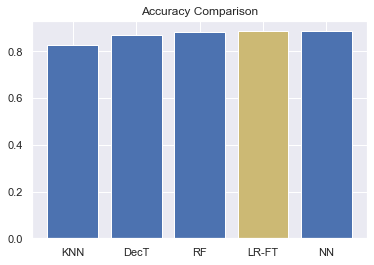

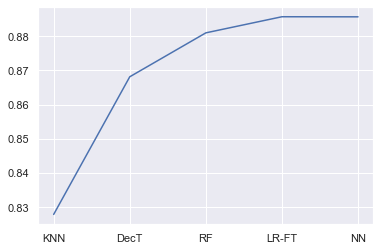

In [191]:
ind=results.index(max(results))
print(names[ind].upper(),'has highest accuracy:',max(results))
plt.title('Accuracy Comparison')
colors=['b','b','b','y','b']
plt.bar(names,results,color=colors)
plt.show()
plt.plot(names,results) 

### Calculate precision score

In [193]:
nn_prec=precision_score(y_test,y_predict_nn)
nn_prec

0.9254851228978008

In [195]:
logreg_res = precision_score(y_test,y_pred_logreg)
logreg_res

0.9579413392363033

In [199]:
k=[]
j=[]
k.append('Neural network')
k.append('Logistic reg Fine tuned')
j.append(nn_prec)
j.append(logreg_res)

LOGISTIC REG FINE TUNED has highest accuracy: 0.8857020547945206


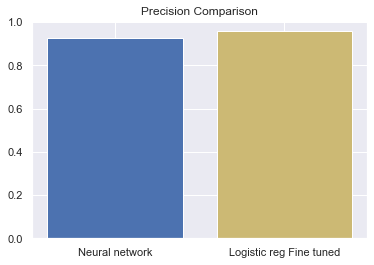

In [204]:
ind=j.index(max(j))
print(k[ind].upper(),'has highest accuracy:',max(results))
plt.title('Precision Comparison')
colors=['b','y']
plt.bar(k,j,color=colors)
plt.show()

### Now we have got more precision accuracy for Logistic regression fine tuned model than neural network